## Anomaly Detection- windowed method 

In [1]:
import numpy as np
import pickle
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.layers import Lambda, Input, Dense, Dropout
from utils.functions import sample, create_sequences, get_error_term
from model.vae_window import vae_window

Importing the dataset

In [2]:
data = pd.read_csv("data/realKnownCause/realKnownCause/nyc_taxi.csv",
                   parse_dates=True, index_col="timestamp")
data

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820
...,...
2015-01-31 21:30:00,24670
2015-01-31 22:00:00,25721
2015-01-31 22:30:00,27309


In [3]:
with open('lists.pkl', 'rb') as f:
    lists = pickle.load(f)

# Access the lists
instances_of_anomaly= lists[2]

In [4]:
data_with_anomaly = data.copy()
data_with_anomaly['anomaly'] = 0
for instance in instances_of_anomaly: 
    start = pd.to_datetime(instance[0])
    end = pd.to_datetime(instance[1])
    data_with_anomaly.loc[(data_with_anomaly.index >= start) & (data_with_anomaly.index <= end), 'anomaly'] = 1

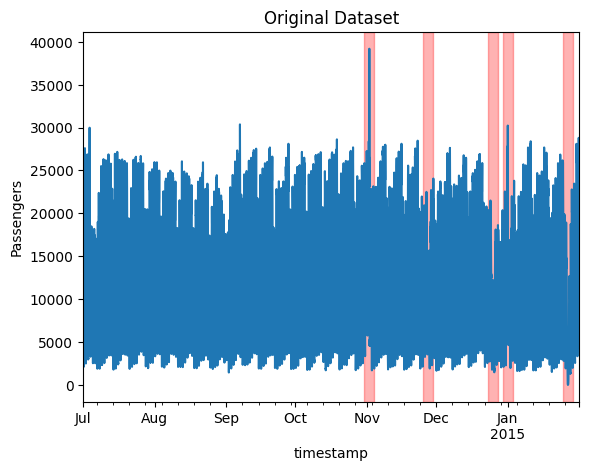

In [5]:
fig, ax = plt.subplots()
data.plot(legend=False, ax=ax)
ax.fill_between(data_with_anomaly.index, 0, 1, where=data_with_anomaly['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(), label='Real anomaly')
plt.ylabel("Passengers")
plt.title("Original Dataset")
plt.show()

Splitting training and testing

In [6]:
# Splitting to train and test
test_ratio =0.4
tr_data = data.iloc[: int(len(data) * (1 - test_ratio))]
tst_data = data.iloc[int(len(data) * (1 - test_ratio)) :]
data_with_anomaly= data_with_anomaly.iloc[int(len(data) * (1 - test_ratio)) :]

In [7]:
tr_data

,value
timestamp,
2014-07-01 00:00:00,10844
2014-07-01 00:30:00,8127
2014-07-01 01:00:00,6210
2014-07-01 01:30:00,4656
2014-07-01 02:00:00,3820
...,...
2014-11-06 21:30:00,26067
2014-11-06 22:00:00,25613
2014-11-06 22:30:00,23971


Normailzing the training set 

In [8]:
# Normalize and save the mean and std we get, for normalizing test data.
training_mean = tr_data.mean()
training_std = tr_data.std()
train_scaled = (tr_data - training_mean) / training_std
print("Number of training samples:", len(train_scaled))

Number of training samples: 6192


Function to create the windowed data

Each sample is half an jour apart, so 336 samples accounts for a week

In [9]:
step_size = 500

train = create_sequences(train_scaled.values, step_size)
print("Training input shape: ", train.shape)

Training input shape:  (5693, 500, 1)


VAE model

In [10]:
vae = vae_window(train, latent_dim=8)
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 500, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 250, 32)   │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 250, 32)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 125, 16)   │      3,600 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 8),       │     35,872 │ input_layer[0][0] │
│ (Functional)        │ (None, 8), (None, │            │                   │
│                     │ 8)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2000)      │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 500, 1)    │     90,081 │ encoder[0][2]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │     16,008 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │     16,008 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer      │ (None, 500, 1)    │          0 │ input_layer[0][0… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 125,953 (492.00 KB)

 Trainable params: 125,953 (492.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# history = vae.fit(
#     train,
#     train,
#     epochs=50,
#     batch_size=128,
#     validation_split=0.1,
#     callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])

In [12]:
from sklearn.model_selection import KFold

# Define the number of folds
n_folds = 5

# Create a KFold object
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=1)

# Initialize a list to hold the history objects returned by the fit method
histories = []

# Loop over the indices returned by kfold.split
for train_index, val_index in kfold.split(train):
    # Generate the training and validation datasets
    train_fold = train[train_index]
    val_fold = train[val_index]

    # Fit the model and append the history object to the list
    history = vae.fit(
        train_fold,
        train_fold,
        epochs=50,
        batch_size=256,
        validation_data=(val_fold, val_fold),
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)]
    )
    histories.append(history)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 122023.4844 - val_loss: 48604.9492
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 51346.5938 - val_loss: 35977.4297
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 40856.5469 - val_loss: 27779.5215
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 30655.7324 - val_loss: 17950.2891
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 20782.0059 - val_loss: 13774.5312
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 16477.6797 - val_loss: 11424.9863
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 14082.0225 - val_loss: 9762.3301
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 12250.3135 - val_loss: 8494.6885
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 10849.1143 - val_loss: 7570.9937
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 9919.3799 - val_loss: 6875.3232
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 9042.4150 - v

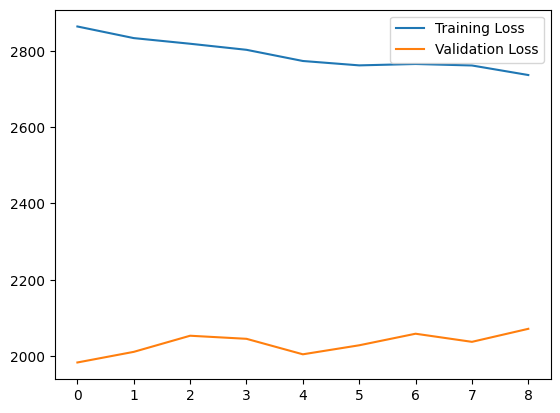

In [13]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

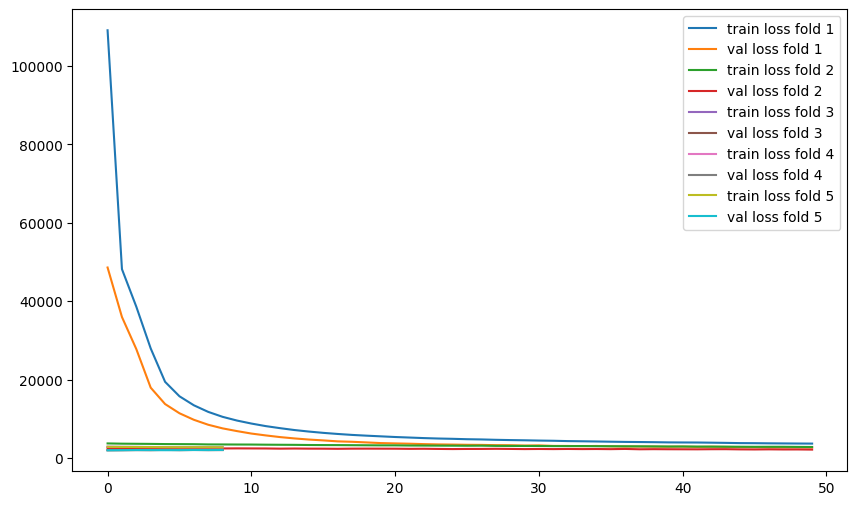

In [14]:
plt.figure(figsize=(10, 6))

# Loop over the history objects
for i, history in enumerate(histories):
    # Plot the training loss
    plt.plot(history.history['loss'], label='train loss fold {}'.format(i+1))
    # Plot the validation loss
    plt.plot(history.history['val_loss'], label='val loss fold {}'.format(i+1))

# Add a legend
plt.legend()

# Show the plot
plt.show()

178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
(5693, 1)


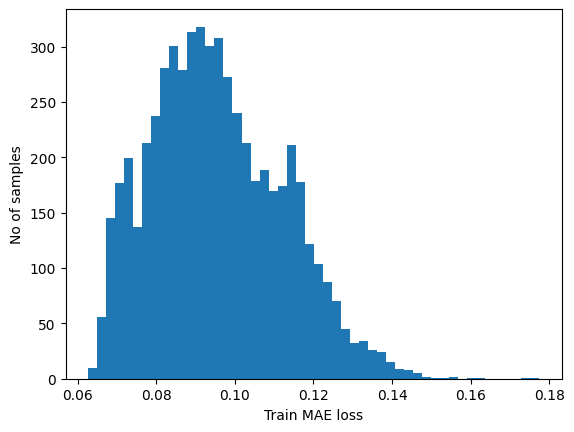

Reconstruction error threshold:  0.17742895693115196


In [15]:
# Get train MAE loss.
train_pred = vae.predict(train)[0]
train_mae_loss = np.mean(np.abs(train_pred - train), axis=1)
print(train_mae_loss.shape)
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [16]:
print(train_pred.shape)

(5693, 500, 1)


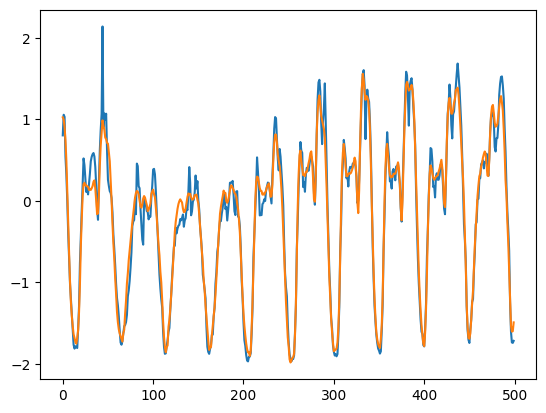

In [17]:
# Checking how the first sequence is learnt
plt.plot(train[90])
plt.plot(train_pred[90])
plt.show()

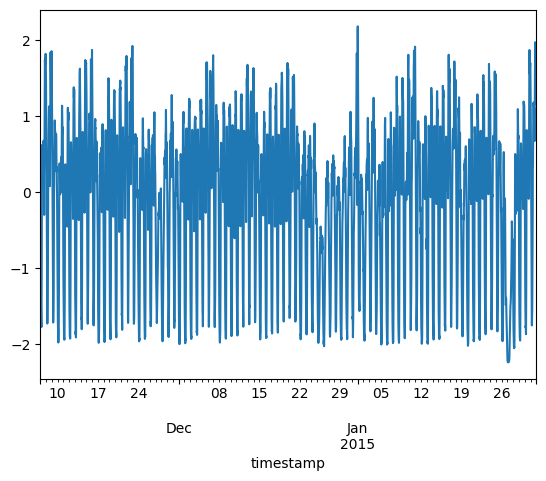

Test input shape:  (3629, 500, 1)
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
(3629, 1)


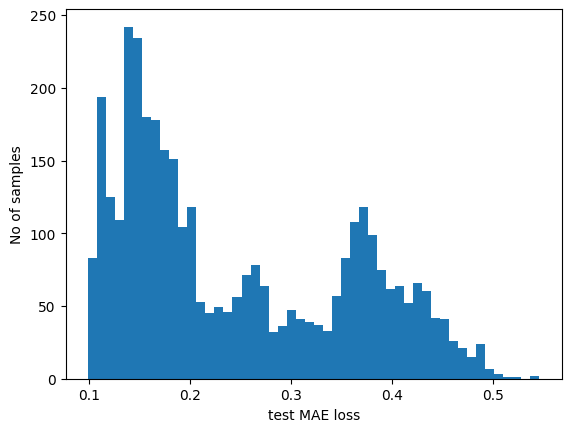

Number of anomaly samples:  2171
Indices of anomaly samples:  (array([ 480,  481,  482, ..., 3626, 3627, 3628], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64))


In [18]:

test_scaled = (tst_data - training_mean) / training_std
fig, ax = plt.subplots()
test_scaled.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
test = create_sequences(test_scaled.values, step_size)
print("Test input shape: ", test.shape)

# Get test MAE loss.
test_pred = vae.predict(test)[0]
test_mae_loss = np.mean(np.abs(test_pred - test), axis=1)
print(test_mae_loss.shape)
#test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [19]:
# anomalous_data_indices = []
# for ind in range(len(anomalies)):
#     if anomalies[ind]:
#         anomalous_data_indices.append(ind)

In [24]:
# data i is an anomaly if more than 90% of samples [(i - timesteps + 1) to (i)] are anomalies
step_size = 288
anomalous_data_indices = []
for data_idx in range(step_size - 1, len(test_scaled) - step_size + 1):
    if np.sum(anomalies[data_idx - step_size + 1 : data_idx]) > step_size * 0.9:
        anomalous_data_indices.append(data_idx)

In [25]:
print("Indices of anomalies: ", anomalous_data_indices)

Indices of anomalies:  [740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 9

In [26]:
df_subset = tst_data.iloc[anomalous_data_indices]
df_subset

,value
timestamp,
2014-11-22 10:00:00,17209
2014-11-22 10:30:00,20299
2014-11-22 11:00:00,20255
2014-11-22 11:30:00,22981
2014-11-22 12:00:00,23368
...,...
2015-01-22 02:00:00,3642
2015-01-22 02:30:00,2769
2015-01-22 03:00:00,2406


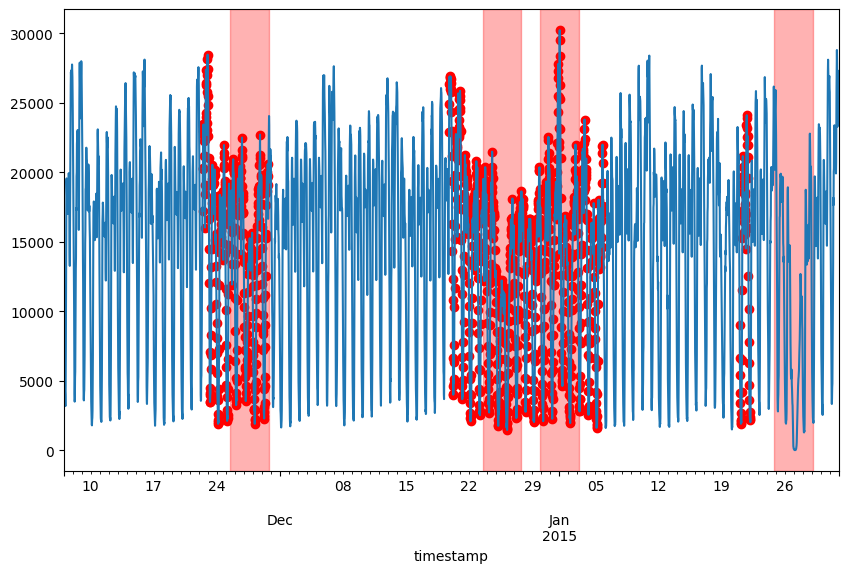

In [27]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))
tst_data.plot(legend=False, ax=ax)
ax.fill_between(data_with_anomaly.index, 0, 1, where=data_with_anomaly['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(), label='Real anomaly')
ax.scatter(df_subset.index, df_subset['value'], color="r")
plt.show()